# Bacteria skeletons for ShapeEmbed
Here, we demonstrate how to prepare a bacteria dataset and extract their skeletons for use with ShapeEmbed. We start with importing relevant libraries and the provided `helpers` module.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage import io
from skimage.color import label2rgb
import pandas as pd
import os
from glob import glob

from helpers import *

## Download the dataset
The cells we're going to use are publicly available in the BioImage archive [here](https://www.ebi.ac.uk/biostudies/bioimages/studies/S-BIAD2354) and are inducible _ponA_ constructs of _Bacillus subtilis_ PY79. For full details of the strains and their construction, please check [the study manuscript](), the results are on Figure 6. You can download them manually yourself or run the following cells.

In the data, we have three different strains (JLG1561, JGL6822, JLG6872), each with six different levels of IPTG for induction (0, 25, 50, 100, 500, and 1000 µM). For purposes of ShapeEmbed consistency, we'll make one directory and a directory for each combination of strain and IPTG

In [4]:
basedir = 'https://ftp.ebi.ac.uk/pub/databases/biostudies/S-BIAD/354/S-BIAD2354/Files/'

samples = pd.read_table(f'{basedir}submission_%20cell_inference_Fig6.tsv')

print(samples.head)

files = np.array(samples['Files'])

strain,iptg = zip(*[f.split('/')[-1].split('_')[:2] for f in files])

dirnames = np.unique([f'{s}_{i}' for s,i in zip(strain,iptg)])

exdirs = []
try:
    os.mkdir('ponA_inductions/')
except:
    pass

for d in dirnames:

    exdirs.append(os.path.join('ponA_inductions/',d))
    
    try:
        os.mkdir(os.path.join('ponA_inductions/',d))
    except:
        pass



<bound method NDFrame.head of                                                 Files  original_omero_ids  \
0    ponA_inductions_masks/JLG1561_0uM_2_cp_masks.tif             9777488   
1    ponA_inductions_masks/JLG1561_0uM_3_cp_masks.tif             9777489   
2    ponA_inductions_masks/JLG1561_0uM_4_cp_masks.tif             9777490   
3    ponA_inductions_masks/JLG1561_0uM_5_cp_masks.tif             9777491   
4    ponA_inductions_masks/JLG1561_0uM_6_cp_masks.tif             9777492   
..                                                ...                 ...   
95  ponA_inductions_masks/JLG6872_50uM_3_cp_masks.tif             9777583   
96  ponA_inductions_masks/JLG6872_50uM_4_cp_masks.tif             9777584   
97  ponA_inductions_masks/JLG6872_50uM_5_cp_masks.tif             9777585   
98  ponA_inductions_masks/JLG6872_50uM_6_cp_masks.tif             9777586   
99  ponA_inductions_masks/JLG6872_50uM_7_cp_masks.tif             9777587   

   imaging_system dye_or_fluorescence image_o

Now that we have our directories, we can read and save the data , but also we'll keep it in memory to then extract the single cells, and from there the skeletons and distance matrices. Our images are instance segmentation masks that we'll need to convert to single cells and then skeletonize and extract the distance matrices.

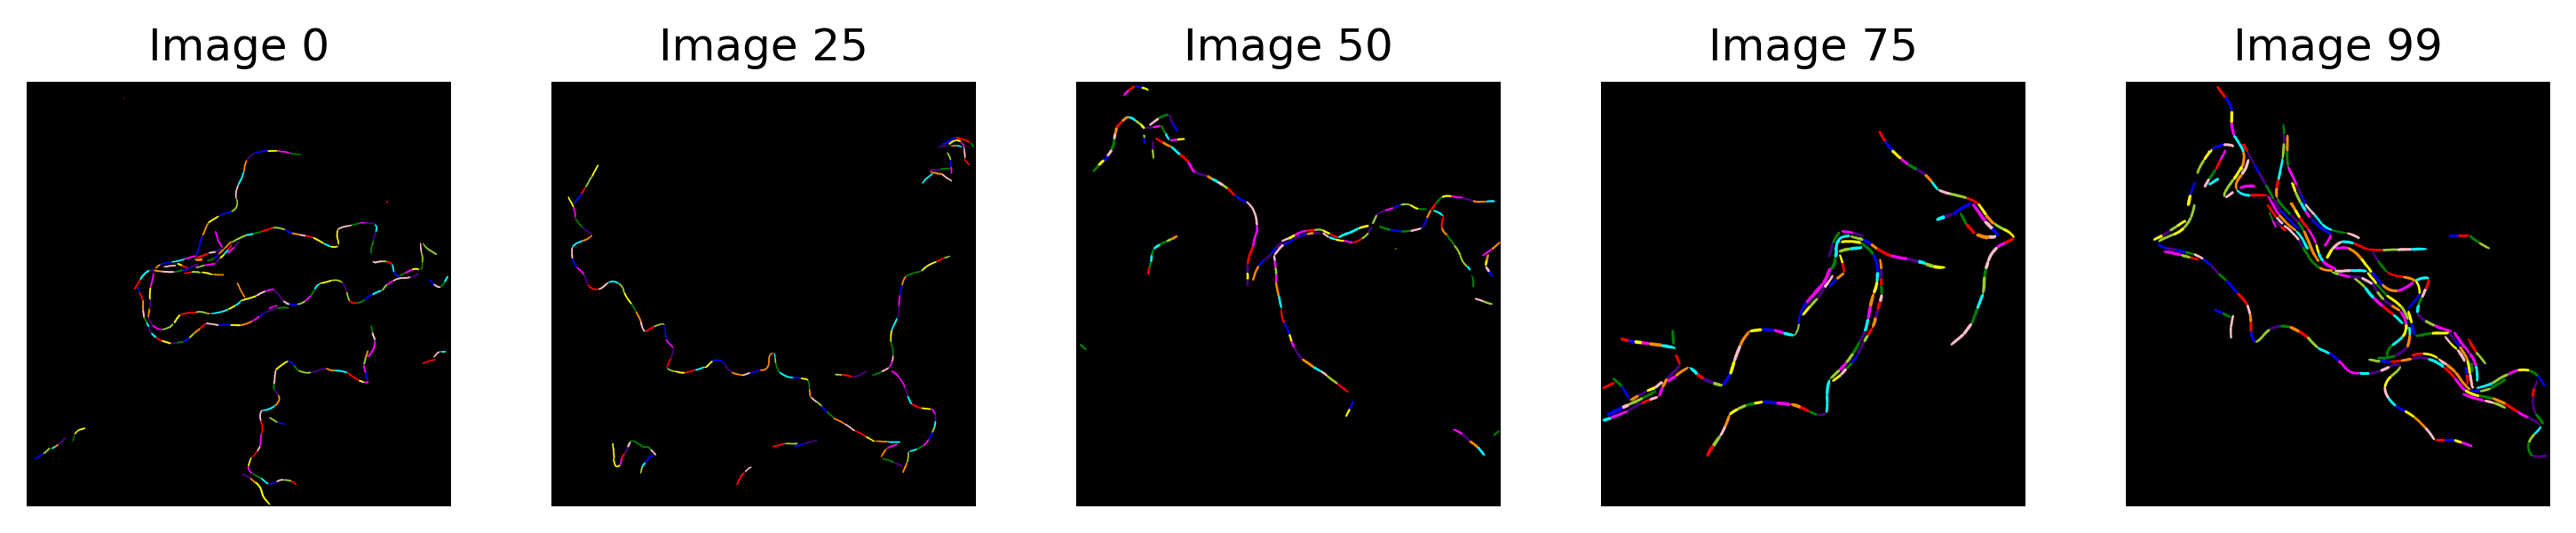

In [3]:
idxs = [0,25,50,75,99]

fig,ax = plt.subplots(dpi=300,ncols=5,figsize=(10,2))

for i,idx in enumerate(idxs):

    img = io.imread(f'{basedir}{files[idx]}')

    ax[i].imshow(label2rgb(img))
    ax[i].axis('off')
    ax[i].set_title(f'Image {idx}')

fig.tight_layout()

To convert the images to single cells, we use the `SingleCellLister` helper function that converts one instance segmentation image into its individual cells

In [2]:
single_cells = []

for e in exdirs:

    lbl = e.split('/')[-1]
    
    files_to_load = [f for f in files if lbl in f ]

    masks = [io.imread(f'{basedir}{f}') for f in files_to_load]

    cells = SingleCellLister(masks)

    for i,c in enumerate(cells):
        io.imsave(f"{e}/{lbl}_c{i}.tif",np.uint8(c),check_contrast=False)

NameError: name 'exdirs' is not defined

## Prepare the dataset
We then prepare the dataset for the next preprocessing steps. Each cell has now their corresponding label in their name and folder, which we can use to differentiate them and also define their labels. 

In [2]:
cell_list = sorted(glob('ponA_inductions/*/*.tif'))

labels = [c.split('/')[1] for c in cell_list]

print(f'{len(cell_list)} cells distributed in {len(np.unique(labels))} conditions')

samples = [(io.imread(cell),lbl) for cell,lbl in zip(cell_list,labels)]

9645 cells distributed in 18 conditions


We now have a list of samples together with their respective labels.

In [3]:
for l in np.unique(labels):

    strain,iptg = l.split('_')

    n_ = len([_ for _, lbl in samples if lbl == l])

    print(f'Found {n_} cells for strain {strain} with {iptg} IPTG')

Found 512 cells for strain JLG1561 with 0uM IPTG
Found 632 cells for strain JLG1561 with 1000uM IPTG
Found 848 cells for strain JLG1561 with 100uM IPTG
Found 507 cells for strain JLG1561 with 25uM IPTG
Found 623 cells for strain JLG1561 with 500uM IPTG
Found 687 cells for strain JLG1561 with 50uM IPTG
Found 292 cells for strain JLG6822 with 0uM IPTG
Found 466 cells for strain JLG6822 with 1000uM IPTG
Found 541 cells for strain JLG6822 with 100uM IPTG
Found 458 cells for strain JLG6822 with 25uM IPTG
Found 611 cells for strain JLG6822 with 500uM IPTG
Found 584 cells for strain JLG6822 with 50uM IPTG
Found 553 cells for strain JLG6872 with 0uM IPTG
Found 328 cells for strain JLG6872 with 1000uM IPTG
Found 636 cells for strain JLG6872 with 100uM IPTG
Found 348 cells for strain JLG6872 with 25uM IPTG
Found 456 cells for strain JLG6872 with 500uM IPTG
Found 563 cells for strain JLG6872 with 50uM IPTG


## Isolate skeletons
For each image we want to extract a sampled, 1D representation of the cell skeleton to then convert it to distance matrices. Our images are already segmented images, that is, they are binary masks with object pixels all white and background pixels all black. Here we show a sample image of an 'alive' worm.

sample 42, label: JLG1561_0uM -- (0: 'alive', 1: 'dead')


Text(0.5, 1.0, 'Resampled Skeleton')

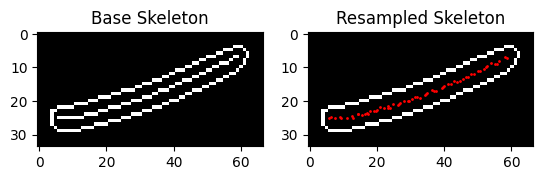

In [4]:
# pick a sample for display purposes
idx_smpl = 42
img_smpl, lbl_smpl = samples[idx_smpl]

img = np.array(img_smpl) > 0
skeleton = skimage.morphology.skeletonize(np.array(img_smpl))
contour = img ^ skimage.morphology.binary_erosion(img)

print(f"sample {idx_smpl}, label: {lbl_smpl} -- (0: 'alive', 1: 'dead')")

plt.subplot(1,2,1)
plt.imshow(contour+skeleton, cmap = 'gray')
plt.title('Base Skeleton')

points = mask2sampledSkel(img_smpl)
plt.subplot(1,2,2)
plt.imshow(contour, cmap = 'gray')
plt.scatter(points[:,1],points[:,0],s=1,c='r')
plt.title('Resampled Skeleton')


We are going to isolate a set of points (with their `(x, y)` coordinates) to represent the skeleton. To do so, we will make use of the provided helper functions `mask2sampledSkel`. To demonstrate:

### Dealing with branching skeletons

Skeletons are not "perfect" 1D representations, and depending on the morphology of the cell they can branch and have multiple edges. What we do is resample candidate skeletons and then we can compute for each a distance matrix and then average them

6 candidate skeletons found


(-0.5, 64.5, 39.5, -0.5)

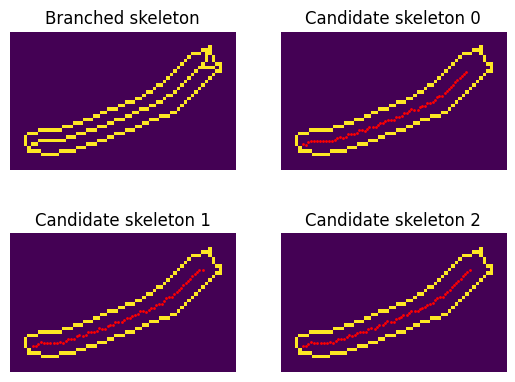

In [6]:
m,lbl = samples[45]

contour = m ^ skimage.morphology.binary_erosion(m)

skeletons = mask2sampledSkel(m)

print(f'{len(skeletons)} candidate skeletons found')

fig,ax = plt.subplots(ncols=2,nrows=2)

ax[0,0].imshow((skeletonize(m)+contour)>0)
ax[0,0].set_title('Branched skeleton')
ax[0,0].axis('off')

ax[0,1].imshow(contour)
ax[0,1].scatter(skeletons[0][:,1],skeletons[0][:,0],s=1,c='r')
ax[0,1].set_title('Candidate skeleton 0')
ax[0,1].axis('off')

ax[1,0].imshow(contour)
ax[1,0].scatter(skeletons[1][:,1],skeletons[1][:,0],s=1,c='r')
ax[1,0].set_title('Candidate skeleton 1')
ax[1,0].axis('off')

ax[1,1].imshow(contour)
ax[1,1].scatter(skeletons[2][:,1],skeletons[2][:,0],s=1,c='r')
ax[1,1].set_title('Candidate skeleton 2')
ax[1,1].axis('off')

In [96]:
outputs = []

i = 1
for s,lbl in samples:

    skeleton_percentage_threshold = 0.85

    points = mask2sampledSkel(s,n_samples=64,skeleton_percentage_threshold=skeleton_percentage_threshold)

    if len(points) == 0:
    
        while True:
            skeleton_percentage_threshold -= 0.025
            if skeleton_percentage_threshold < 0.6: break
        
            points = mask2sampledSkel(s,n_samples=64,skeleton_percentage_threshold=skeleton_percentage_threshold)
        
            if len(points) > 0: break

    if len(points) > 0:
        outputs.append((points,lbl))

    i+=1

In [101]:
print(len(outputs))
print(len(samples))

9553
9645


## Convert to distance matrices
Now that we have the contours of the objects as a set of `(x, y)` coordinates, we can turn them into distance matrices for use by ShapeEmbed. We use the provided `distance_matrix` re-exported from the `scipy.spatial` library by our `helpers` module. It takes a set of point coordinates and derive a matrix of distances between points.

Since some have multiple candidate skeletons, we'll do this in a loop and average the resulting distance matrices:

In [130]:
samples_dm = []

for o in outputs:
    
    c,lbl = o

    if len(c) == 64:
        samples_dm.append((distance_matrix(c,c),lbl))

    else:
        dms = np.array([distance_matrix(cc,cc) for cc in c])
        samples_dm.append((dms.mean(axis=0),lbl))
     

## Split our samples into two train / test sets
We will turn our `samples_dm` list into two `_train` and `_test` lists with respectively `80%` and `20%` of the available data. We will use the `train_test_split` function from the `sklearn` module to achieve this in a stratified manner (keeping the `80%`/`20%` split accross labels).

In [132]:
# isolate the distance matrices `X` and the labels `y`
X = [dm for dm, _ in samples_dm]
y = [lbl for _, lbl in samples_dm]

# stratified split, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y
  , test_size = 0.2
  , stratify = y
  , random_state = 42
)

# recombine distance matrices and labels
samples_dm_train = list(zip(X_train, y_train))
samples_dm_test = list(zip(X_test, y_test))

## Save the distance matrices to disk for use as a `torch` `DatasetFolder`
Now that we have our distance matrices ready, we save them on disk for use by ShapeEmbed. We will create a `_train` folder and a `_test` folder each with a `alive` and a `dead` subfolder. The files contained in the subfolders will be the `.npy` numpy arrays for the distance matrices. This folder structure is compatible with the `torch` [`DatasetFolder`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.DatasetFolder.html#datasetfolder) class in use by ShapeEmbed.

In [145]:
try:
    os.mkdir(os.path.join('ponA_inductions','dm_train'))
except:
    pass

try:
    os.mkdir(os.path.join('ponA_inductions','dm_test'))
except:
    pass


for directory in y:

    try:
        os.mkdir(os.path.join('ponA_inductions','dm_train',directory))
    except:
        pass

    try:
        os.mkdir(os.path.join('ponA_inductions','dm_test',directory))
    except:
        pass

In [152]:
exdir_train = 'ponA_inductions/dm_train'
exdir_test = 'ponA_inductions/dm_test'

for idx, (dm,lbl) in enumerate(samples_dm_train):

    np.save(f'{exdir_train}/{lbl}/sample_{idx}.npy', dm)

for idx, (dm,lbl) in enumerate(samples_dm_test):

    np.save(f'{exdir_test}/{lbl}/sample_{idx}.npy', dm)